### Step 1 -- downloading imageStack

In [1]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set(font_scale=2)
sns.set_style("white")

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import imageio

import os, sys
fish_path = os.path.abspath(os.path.join('..'))
if fish_path not in sys.path:
    sys.path.append(fish_path)

In [2]:
folderName = '/groups/ahrens/ahrenslab/Takashi/toZiqiang/02212018Fish2-1/'

### Camera infomation

In [3]:
from utils import getCameraInfo
cameraInfo = getCameraInfo.getCameraInfo(folderName)

In [4]:
pixel_x0, pixel_x1, pixel_y0, pixel_y1 = [int(_) for _ in cameraInfo['camera_roi'].split('_')]
pixel_x = (pixel_x0, pixel_x1)
pixel_y = (pixel_y0, pixel_y1)

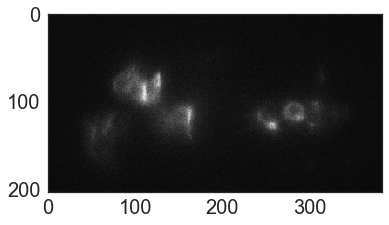

In [5]:
imgFileName = 'Raw_stack.tif'
imgFile = os.path.join(folderName, imgFileName)
imgStack = io.imread(imgFile)
# check the first image
plt.imshow(imgStack[0], cmap='gray')
# plt.colorbar()
plt.show()

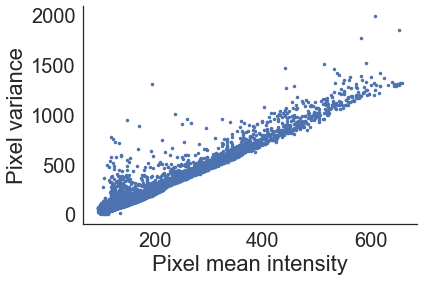

In [6]:
plt.plot(imgStack.mean(axis=0).reshape(-1), imgStack.var(axis=0).reshape(-1), '.')
plt.xlabel('Pixel mean intensity')
plt.ylabel('Pixel variance')
sns.despine()
plt.show()

### Step 2 -- simple denoising

In [7]:
cameraNoiseMat = '/groups/ahrens/ahrenslab/Ziqiang/gainMat/gainMat20180208'

In [8]:
offset = np.load(cameraNoiseMat +'/offset_mat.npy')
gain = np.load(cameraNoiseMat +'/gain_mat.npy')
offset_ = offset[pixel_x[0]:pixel_x[1], pixel_y[0]:pixel_y[1]]
gain_ = gain[pixel_x[0]:pixel_x[1], pixel_y[0]:pixel_y[1]]

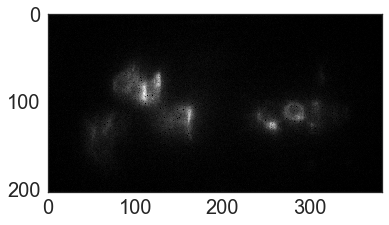

In [9]:
from pixelwiseDenoising.simpleDenioseTool import simpleDN
imgD = simpleDN(imgStack, offset=offset_, gain=gain_)
plt.imshow(imgD[0], cmap='gray')
# plt.colorbar()
plt.show()

### Step 2.1 -- smooth dead pixels using median filter (1 for time)

In [10]:
# from pixelwiseDenoising.simpleDenioseTool import smoothDeadPixelBoxCar
# imgD_ = smoothDeadPixelBoxCar(imgD)
# plt.imshow(imgD_[0], cmap='gray',vmax=300, vmin=0)
# plt.colorbar()
# plt.show()
# imgD_ = imgD.copy()
from scipy.ndimage.filters import median_filter
win_ = 3
imgD_ = median_filter(imgD, size=(1, win_, win_))

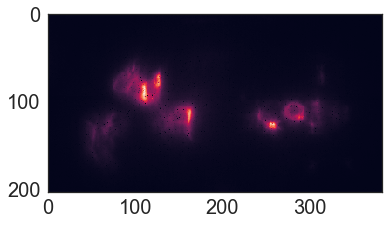

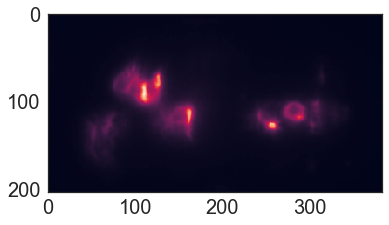

In [11]:
# plt.figure(figsize=(20,10))
plt.imshow(imgD.mean(axis=0))
plt.show()
# plt.figure(figsize=(20,10))
plt.imshow(imgD_.mean(axis=0))
plt.show()

### Step 3 -- motion detection / image registration

In [12]:
from imageRegistration.imTrans import ImAffine
trans = ImAffine()
trans.level_iters = [1000, 1000, 100]
trans.ss_sigma_factor = 1.0

### Step 3.1 -- from the first and last frame to decide if motion correction is neccessary

In [13]:
# %%time
# fix = imgD_[0]
# move = imgD_[len(imgD_)-1]
# trans_affine = trans.estimate_rigid2d(fix, move)

### 3.2 -- motion detection (create movie)

### 3.3 -- motion correction for both raw and denoised image

In [14]:
from utils.np_mp import parallel_to_chunks

In [15]:
t_ = len(imgStack)//2
win_ = 150
fix = imgStack[t_-win_:t_+win_].mean(axis=0)
fix_ = imgD_[t_-win_:t_+win_].mean(axis=0)

def regidStacks(move, fix=fix):
    if move.ndim < 3:
        move = move[np.newaxis, :]    
    trans_move = move.copy()
    move_list = []    
    for nframe, move_ in enumerate(move):
        trans_affine = trans.estimate_rigid2d(fix, move_)
        trans_mat = trans_affine.affine
        trans_move[nframe] = trans_affine.transform(move_)
        move_list.append([trans_mat[0, 1]/trans_mat[0, 0], trans_mat[0, 2], trans_mat[1, 2]])
    return trans_move, move_list

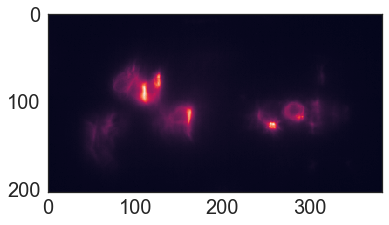

In [17]:
plt.imshow(fix)
plt.show()

In [18]:
imgStackMotion, imgStackMotionVar = parallel_to_chunks(regidStacks, imgStack, fix=fix)
imgDMotion, imgDMotionVar = parallel_to_chunks(regidStacks, imgD_, fix=fix_)

In [19]:
np.save('tmpData/imgStackMotion', imgStackMotion)
np.save('tmpData/imgStackMotionVar', imgStackMotionVar)
np.save('tmpData/imgDMotion', imgDMotion)
np.save('tmpData/imgDMotionVar', imgDMotionVar)

In [20]:
imgStackMotion = np.load('tmpData/imgStackMotion.npy')
imgDMotion = np.load('tmpData/imgDMotion.npy')
imgStackMotionVar = np.load('tmpData/imgStackMotionVar.npy')
imgDMotionVar = np.load('tmpData/imgDMotionVar.npy')

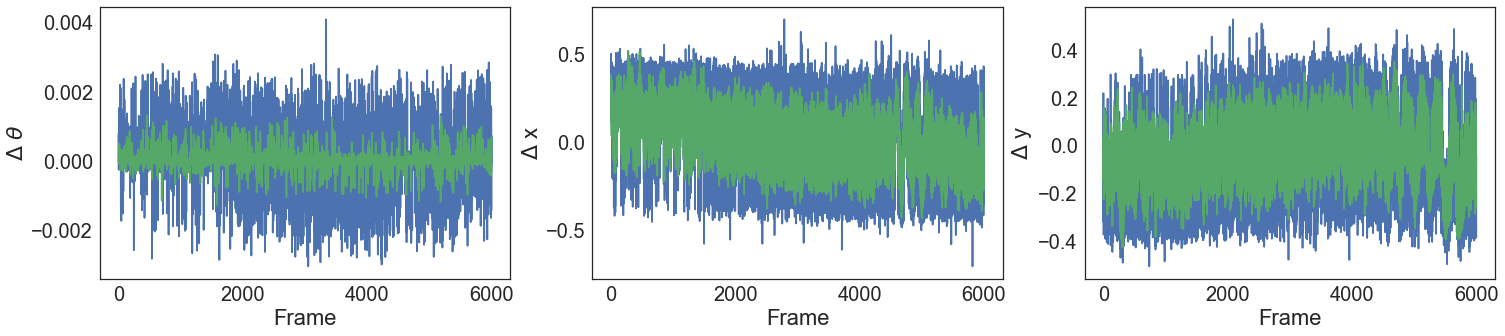

In [21]:
title = [r'$\theta$', 'x', 'y']
f, ax = plt.subplots(1, 3, figsize = (25, 5))
for nplot in range(3):
    ax[nplot].plot(imgStackMotionVar[:, nplot]) # phase, x, y
    ax[nplot].plot(imgDMotionVar[:, nplot])
    ax[nplot].set_ylabel(r'$\Delta$ ' + title[nplot])
    ax[nplot].set_xlabel('Frame')
plt.show()

In [22]:
# from utils.video import videoWrite
# videoWrite(imgStack[1:], 'imgStack.mp4', fps=30)
# videoWrite(imgD_[1:], 'imgD.mp4', fps=30)
# videoWrite(imgStackMotion, 'imgStackMotion.mp4', fps=30)
# videoWrite(imgDMotion, 'imgDMotion.mp4', fps=30)

### Step 4 -- crop a cell

In [23]:
crop_x = (65, 90)
crop_y = (70, 100)

In [24]:
mask = np.zeros(fix.shape)
mask[crop_x[0]:crop_x[1], crop_y[0]:crop_y[1]] = 1

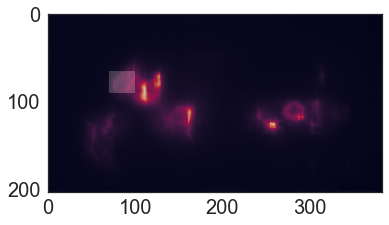

In [25]:
plt.imshow(fix)
plt.imshow(mask, alpha=0.2)
plt.show()

### Step 5 -- compute df/f

In [26]:
cropRaw = imgStackMotion[:, mask==1]
cropSDN = imgDMotion[:, mask==1]

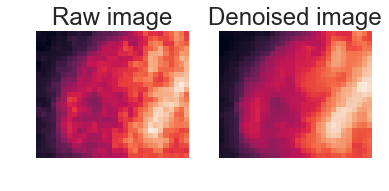

In [27]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(cropRaw[0].reshape(crop_x[1]-crop_x[0], crop_y[1]-crop_y[0]))
ax1.set_title('Raw image')
ax1.axis('off')
ax2.imshow(cropSDN[0].reshape(crop_x[1]-crop_x[0], crop_y[1]-crop_y[0]))
ax2.set_title('Denoised image')
ax2.axis('off')
plt.show()

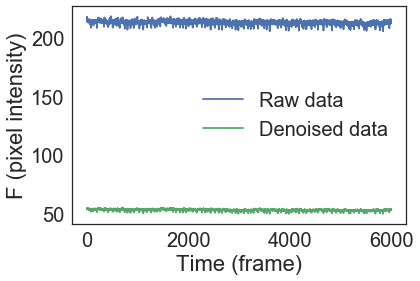

In [28]:
plt.plot(cropRaw.mean(axis=1), label='Raw data')
plt.plot(cropSDN.mean(axis=1), label='Denoised data')
plt.ylabel('F (pixel intensity)')
plt.xlabel('Time (frame)')
plt.legend()
plt.show()

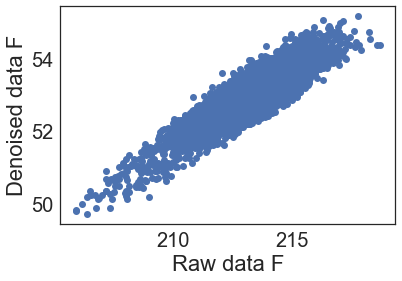

In [29]:
plt.plot(cropRaw.mean(axis=1), cropSDN.mean(axis=1), 'o')
plt.xlabel('Raw data F')
plt.ylabel('Denoised data F')
plt.show()

In [30]:
def compute_dff(sig):
    bg = np.percentile(sig, 5, axis=1)
    return (sig.mean(axis=1)-sig.mean(axis=1).mean())/(sig.mean(axis=1).mean()-bg)

In [31]:
dff_raw = compute_dff(cropRaw)
dff_sdn = compute_dff(cropSDN)

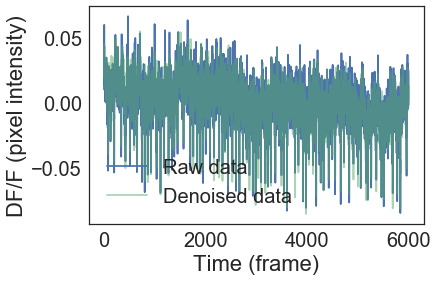

In [32]:
plt.plot(dff_raw, label='Raw data')
plt.plot(dff_sdn, label='Denoised data', alpha=0.5)
plt.ylabel('DF/F (pixel intensity)')
plt.xlabel('Time (frame)')
plt.legend()
plt.show()

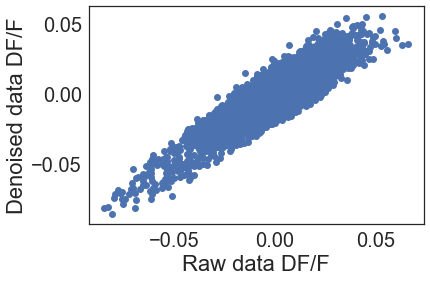

In [33]:
plt.plot(dff_raw, dff_sdn, 'o')
plt.xlabel('Raw data DF/F')
plt.ylabel('Denoised data DF/F')
plt.show()